In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.layers.core import Activation
from keras.utils import pad_sequences

2023-02-27 11:58:14.237421: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the data
df = pd.read_csv('../Data/cleaned_Pond2.csv', delimiter=',', low_memory=False )

In [3]:
df.drop("Unnamed: 0",axis=1,inplace=True)
df.drop("Population",axis=1,inplace=True)
df.drop("Date",axis=1,inplace=True)
df.drop("Time",axis=1,inplace=True)
df.drop("Weight_diff",axis=1,inplace=True)
df.drop("Fish_Length",axis=1,inplace=True)
df.drop("Fish_Weight",axis=1,inplace=True)
df.head(5)

,Temperature,Turbidity,Dissolved Oxygen,PH,Ammonia,Nitrate,Datetime
0,24.8750,100,4.505,8.43365,0.38,193,2021-06-19 00:00:05
1,24.9375,100,6.601,8.43818,0.38,194,2021-06-19 00:01:02
2,24.8750,100,15.797,8.42457,0.38,192,2021-06-19 00:01:22
3,24.9375,100,5.046,8.43365,0.38,193,2021-06-19 00:01:44
4,24.9375,100,38.407,8.40641,0.38,192,2021-06-19 00:02:07


In [4]:
df['Datetime'] = pd.to_datetime(df.Datetime,infer_datetime_format=True)
df.set_index("Datetime",inplace=True)
df=df.resample('min').ffill()
df=df.bfill()

In [5]:
df.reset_index(inplace=True)

In [6]:
df.head()

,Datetime,Temperature,Turbidity,Dissolved Oxygen,PH,Ammonia,Nitrate
0,2021-06-19 00:00:00,24.8750,100.0,4.505,8.43365,0.38,193.0
1,2021-06-19 00:01:00,24.8750,100.0,4.505,8.43365,0.38,193.0
2,2021-06-19 00:02:00,24.9375,100.0,5.046,8.43365,0.38,193.0
3,2021-06-19 00:03:00,24.8750,100.0,2.831,8.43818,0.38,194.0
4,2021-06-19 00:04:00,24.8750,100.0,17.005,8.43365,0.38,192.0


In [7]:
df.describe()

,Temperature,Turbidity,Dissolved Oxygen,PH,Ammonia,Nitrate
count,192960.00000,192960.000000,192960.000000,192960.000000,1.929600e+05,192960.000000
mean,24.90110,95.079519,6.784840,5.186690,1.644444e+08,749.050643
std,0.82809,16.312601,9.219671,3.238303,8.591875e+09,408.174637
min,23.00000,1.000000,0.007000,-3.137450,6.770000e-03,61.000000
25%,24.25000,100.000000,2.163000,2.446090,8.196800e-01,204.000000
50%,24.81250,100.000000,3.200000,7.003710,5.979360e+00,938.000000
75%,25.43750,100.000000,6.795000,7.421340,2.608377e+01,1072.000000
max,27.81250,100.000000,41.011000,8.551670,9.965130e+11,2077.000000


In [8]:
def percentage(percent, whole):
  return (percent * whole) / 100.0

In [9]:
chunk_prctg=40
training_prctg=80
validation_prctg=20

rows_to_work_with=round(percentage(chunk_prctg, df.shape[0]))
print('rows_to_work_with ',rows_to_work_with)
training_rows_to_work_with=round(percentage(training_prctg, rows_to_work_with))
print('training_rows_to_work_with',training_rows_to_work_with)

rows_to_work_with  77184
training_rows_to_work_with 61747


In [10]:
# It does not make sense to randomize our data . In machine learning, train/test split splits the data randomly, 
# as there’s no dependence from one observation to the other. That’s not the case with our time series data.
# Here, we’ll want to use values at the rear of the dataset for testing and everything else for training.
# create your training and validation sets here
start_index=0
train_df = df[start_index:training_rows_to_work_with]
val_df = df[training_rows_to_work_with:rows_to_work_with]

<AxesSubplot:>

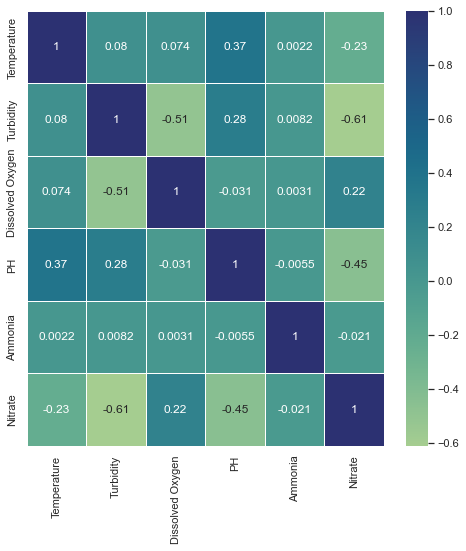

In [11]:
import seaborn as sns; sns.set()
plt.figure(figsize=(8,8))
sns.heatmap(train_df.corr(), annot=True, cmap='crest',linewidth=.5  )

In [12]:
val_df.to_csv('../Data/val_df.csv', index=False)

In [13]:
# #  Importing the dataset (Original Cleaned Dataset)
# train_df = pd.read_csv('../Data/train_df.csv')
# val_df = pd.read_csv('../Data/val_df.csv')

Temperature Predictions: 

In [14]:
# X_train = train_df.drop("Temperature",axis=1)
X_train = train_df[['Temperature','PH']]
y_train = train_df['Temperature']
# X_test = val_df.drop("Temperature",axis=1)
X_test = val_df[['Temperature','PH']]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on your training data
scaler.fit(X_train)

X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)


Preparing our Training Data sequences with label predictions

In [15]:
# we'll start out with a 2 minute input sequence and a one minute predictive horizon
seq_arrays = []
seq_labs = []
seq_length = 2
ph = 1


num_train_rows=train_df.shape[0]

#create list of sequence length Temperature readings
for start in range(0,num_train_rows-seq_length-ph):
    seq_arrays.append(X_train_norm[start:start+seq_length])
#     seq_arrays.append(train_df[feat_cols].iloc[start:start+seq_length].to_numpy())
    seq_labs.append([train_df['Temperature'].iloc[start:start+seq_length+1].to_numpy()[-1]])

seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [16]:
seq_arrays.shape

(61744, 2, 2)

In [17]:
seq_labs.shape

(61744, 1)

Preparing our Test Data sequences with label predictions

In [18]:
val_arrays = []
val_labs = []

num_test_rows=val_df.shape[0]

i=1

#create list of Temperature readings starting with a minimum of two readings
for start in range(2,num_test_rows):
    incoming_df=val_df[0:start] 
    
    if len(incoming_df) > seq_length: 
        
        val_arrays.append(X_test_norm[i:i+seq_length])
        val_labs.append([incoming_df['Temperature'].iloc[i:i+seq_length+ph].to_numpy()[-1]])
        i+=1
        
    else:
        
        val_arrays.append(X_test_norm[0:len(incoming_df)])
        val_labs.append([incoming_df['Temperature'].iloc[0:len(incoming_df)+ph].to_numpy()[-1]])
        
# use the pad_sequences function on your input sequences
val_arrays = tf.keras.preprocessing.sequence.pad_sequences(val_arrays, dtype='float32', padding='post',value=val_df["Temperature"].mean())     

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

In [19]:
val_arrays.shape

(15435, 2, 2)

In [20]:
val_labs.shape

(15435, 1)



## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a linear final layer and MSE for our loss function, since our output is continuous instead of binary.


CNN-LSTM Model

In [21]:
from keras.layers import Conv1D, BatchNormalization
model_path = './Models/CNN_LSTM_model_temperature.h5'
# build the network
nb_features = seq_arrays.shape[2]
nb_out = seq_labs.shape[1]
model = Sequential()

model.add(Conv1D(32,input_shape=(seq_length, nb_features),kernel_size=2, padding="causal",activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(48,kernel_size=2,padding="causal",activation="relu",dilation_rate=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(64,kernel_size=2,padding="causal",activation="relu",dilation_rate=4))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(units = nb_out))
model.add(Activation("linear"))
optimizer = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
print(model.summary())

2023-02-27 11:58:39.534291: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 32)             160       
                                                                 
 batch_normalization (BatchN  (None, 2, 32)            128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 2, 32)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 48)             3120      
                                                                 
 batch_normalization_1 (Batc  (None, 2, 48)            192       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 2, 48)             0

In [22]:
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=50,validation_split=0.05, verbose=2,
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=10, verbose=0, mode='min'),
keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True,mode='min', verbose=0)])
# list all data in history
print(history.history.keys())

Epoch 1/100
1174/1174 - 19s - loss: 58.8124 - mse: 58.8124 - val_loss: 0.1086 - val_mse: 0.1086 - 19s/epoch - 16ms/step
Epoch 2/100
1174/1174 - 8s - loss: 3.4391 - mse: 3.4391 - val_loss: 0.0124 - val_mse: 0.0124 - 8s/epoch - 7ms/step
Epoch 3/100
1174/1174 - 8s - loss: 3.1972 - mse: 3.1972 - val_loss: 0.0148 - val_mse: 0.0148 - 8s/epoch - 7ms/step
Epoch 4/100
1174/1174 - 8s - loss: 3.0472 - mse: 3.0472 - val_loss: 0.0213 - val_mse: 0.0213 - 8s/epoch - 7ms/step
Epoch 5/100
1174/1174 - 8s - loss: 2.9728 - mse: 2.9728 - val_loss: 0.0026 - val_mse: 0.0026 - 8s/epoch - 7ms/step
Epoch 6/100
1174/1174 - 8s - loss: 2.8974 - mse: 2.8974 - val_loss: 0.0073 - val_mse: 0.0073 - 8s/epoch - 7ms/step
Epoch 7/100
1174/1174 - 8s - loss: 2.8297 - mse: 2.8297 - val_loss: 0.0232 - val_mse: 0.0232 - 8s/epoch - 7ms/step
Epoch 8/100
1174/1174 - 8s - loss: 2.7098 - mse: 2.7098 - val_loss: 0.0089 - val_mse: 0.0089 - 8s/epoch - 7ms/step
Epoch 9/100
1174/1174 - 8s - loss: 2.5847 - mse: 2.5847 - val_loss: 0.0050 

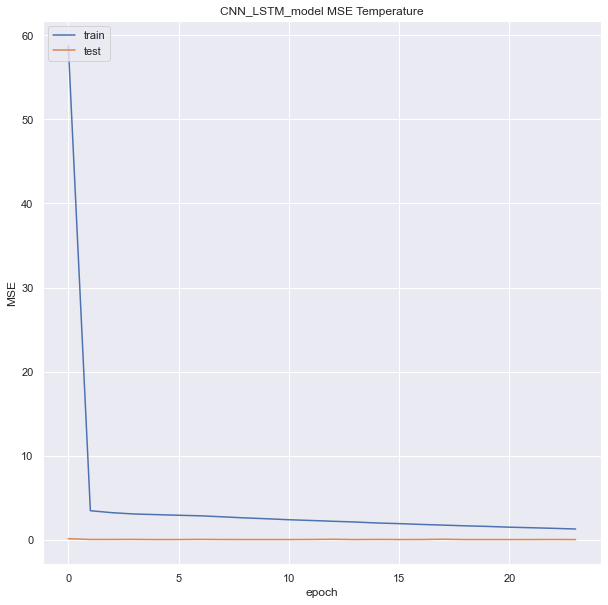

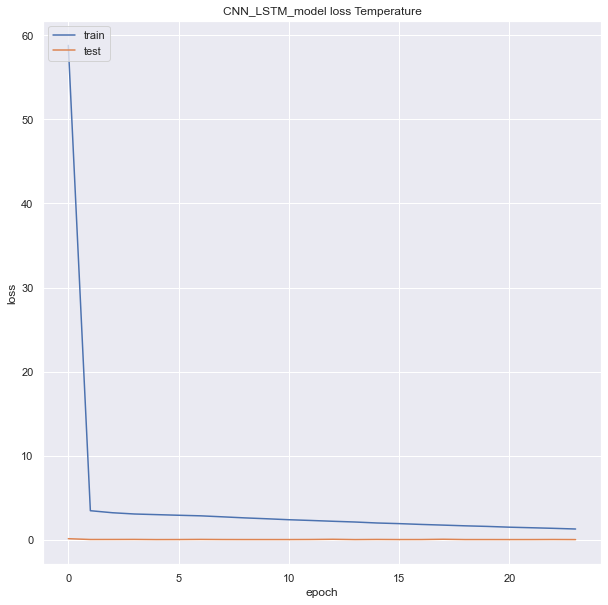

In [23]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('CNN_LSTM_model MSE Temperature')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_mse_temperature.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN_LSTM_model loss Temperature')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_loss_temperature.png")


We will now run this validation data through our CNN-LSTM model and visualize its performance 

483/483 - 1s - loss: 0.0031 - mse: 0.0031 - 1s/epoch - 3ms/step

MSE: 0.003112237434834242
483/483 [==============================] - 3s 3ms/step


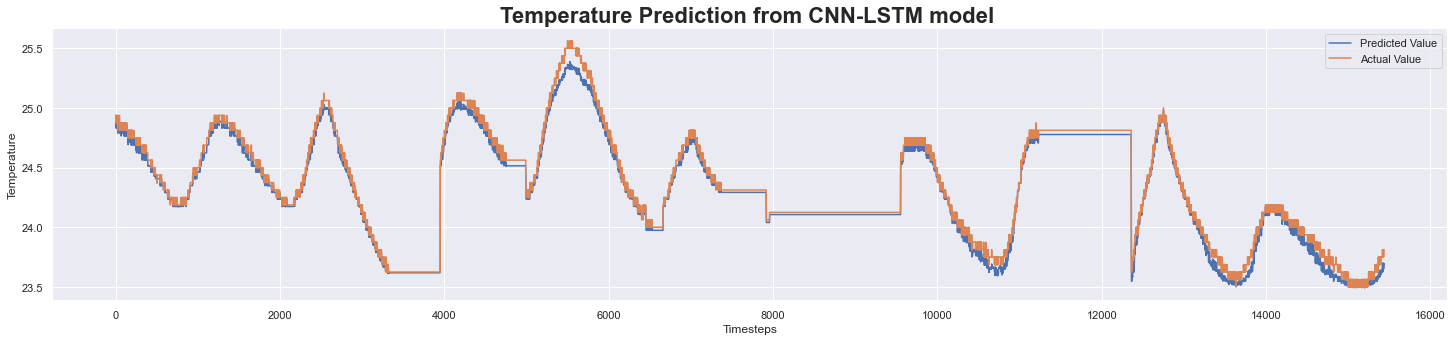

In [24]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('./Predictions/temperature_predictions.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(25, 5))
# plt.plot(y_pred_test[-100:], label = 'Predicted Value')
# plt.plot(y_true_test[-100:], label = 'Actual Value')
plt.plot(y_pred_test, label = 'Predicted Value')
plt.plot(y_true_test, label = 'Actual Value')
plt.title('Temperature Prediction from CNN-LSTM model ', fontsize=22, fontweight='bold')
plt.ylabel('Temperature')
plt.xlabel('Timesteps')
plt.legend()
plt.show()
fig_verify.savefig("./Images/temperature_predictions.png")

pH Predictions

In [25]:
# X_train = train_df.drop("Temperature",axis=1)
X_train = train_df[['Temperature','PH']]
y_train = train_df['PH']
# X_test = val_df.drop("Temperature",axis=1)
X_test = val_df[['Temperature','PH']]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on your training data
scaler.fit(X_train)

X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

In [26]:
# we'll start out with a 2 minute input sequence and a one minute predictive horizon
seq_arrays = []
seq_labs = []
seq_length = 2
ph = 1


num_train_rows=train_df.shape[0]

#create list of sequence length Temperature readings
for start in range(0,num_train_rows-seq_length-ph):
    seq_arrays.append(X_train_norm[start:start+seq_length])
#     seq_arrays.append(train_df[feat_cols].iloc[start:start+seq_length].to_numpy())
    seq_labs.append([train_df['PH'].iloc[start:start+seq_length+1].to_numpy()[-1]])

seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [27]:
val_arrays = []
val_labs = []

num_test_rows=val_df.shape[0]

i=1

#create list of Temperature readings starting with a minimum of two readings
for start in range(2,num_test_rows):
    incoming_df=val_df[0:start] 
    
    if len(incoming_df) > seq_length: 
        
        val_arrays.append(X_test_norm[i:i+seq_length])
        val_labs.append([incoming_df['PH'].iloc[i:i+seq_length+ph].to_numpy()[-1]])
        i+=1
        
    else:
        
        val_arrays.append(X_test_norm[0:len(incoming_df)])
        val_labs.append([incoming_df['PH'].iloc[0:len(incoming_df)+ph].to_numpy()[-1]])
        
# use the pad_sequences function on your input sequences
val_arrays = tf.keras.preprocessing.sequence.pad_sequences(val_arrays, dtype='float32', padding='post',value=val_df["PH"].mean())     

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

In [28]:
print(val_arrays.shape,val_labs.shape,seq_arrays.shape,seq_labs.shape)

(15435, 2, 2) (15435, 1) (61744, 2, 2) (61744, 1)


In [29]:
from keras.layers import Conv1D, BatchNormalization
model_path = './Models/CNN_LSTM_model_pH.h5'
# build the network
nb_features = seq_arrays.shape[2]
nb_out = seq_labs.shape[1]
model = Sequential()

model.add(Conv1D(32,input_shape=(seq_length, nb_features),kernel_size=2, padding="causal",activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(48,kernel_size=2,padding="causal",activation="relu",dilation_rate=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(64,kernel_size=2,padding="causal",activation="relu",dilation_rate=4))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(units = nb_out))
model.add(Activation("linear"))
optimizer = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 2, 32)             160       
                                                                 
 batch_normalization_3 (Batc  (None, 2, 32)            128       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 2, 32)             0         
                                                                 
 conv1d_4 (Conv1D)           (None, 2, 48)             3120      
                                                                 
 batch_normalization_4 (Batc  (None, 2, 48)            192       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 2, 48)            

In [30]:
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=50,validation_split=0.05, verbose=2,
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=10, verbose=0, mode='min'),
keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True,mode='min', verbose=0)])
# list all data in history
print(history.history.keys())

Epoch 1/100
1174/1174 - 12s - loss: 2.2995 - mse: 2.2995 - val_loss: 0.0215 - val_mse: 0.0215 - 12s/epoch - 10ms/step
Epoch 2/100
1174/1174 - 7s - loss: 0.3555 - mse: 0.3555 - val_loss: 0.0190 - val_mse: 0.0190 - 7s/epoch - 6ms/step
Epoch 3/100
1174/1174 - 8s - loss: 0.3089 - mse: 0.3089 - val_loss: 0.0056 - val_mse: 0.0056 - 8s/epoch - 7ms/step
Epoch 4/100
1174/1174 - 8s - loss: 0.2870 - mse: 0.2870 - val_loss: 4.0374e-04 - val_mse: 4.0374e-04 - 8s/epoch - 6ms/step
Epoch 5/100
1174/1174 - 8s - loss: 0.2597 - mse: 0.2597 - val_loss: 3.1668e-04 - val_mse: 3.1668e-04 - 8s/epoch - 7ms/step
Epoch 6/100
1174/1174 - 8s - loss: 0.2391 - mse: 0.2391 - val_loss: 0.0033 - val_mse: 0.0033 - 8s/epoch - 7ms/step
Epoch 7/100
1174/1174 - 9s - loss: 0.2144 - mse: 0.2144 - val_loss: 0.0061 - val_mse: 0.0061 - 9s/epoch - 7ms/step
Epoch 8/100
1174/1174 - 8s - loss: 0.1859 - mse: 0.1859 - val_loss: 1.2293e-04 - val_mse: 1.2293e-04 - 8s/epoch - 7ms/step
Epoch 9/100
1174/1174 - 8s - loss: 0.1629 - mse: 0.16

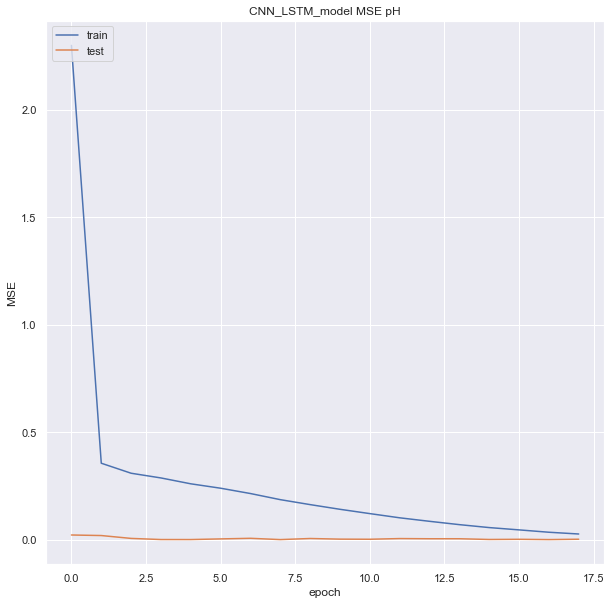

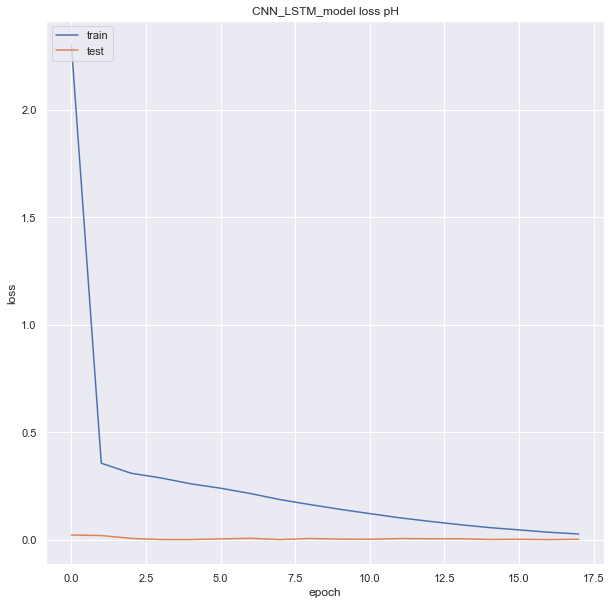

In [31]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('CNN_LSTM_model MSE pH')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_mse_pH.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN_LSTM_model loss pH')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_loss_pH.png")


483/483 - 2s - loss: 0.0169 - mse: 0.0169 - 2s/epoch - 3ms/step

MSE: 0.016882259398698807
483/483 [==============================] - 4s 4ms/step


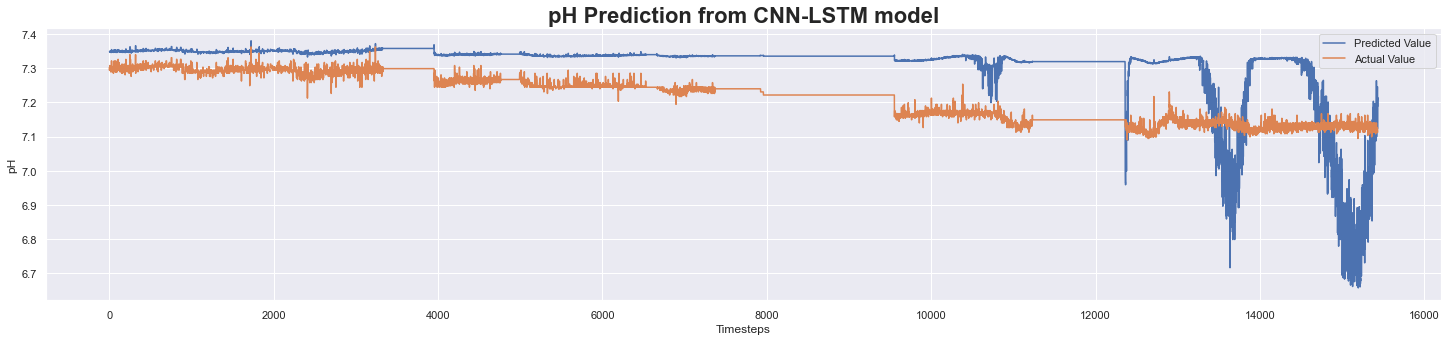

In [32]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('./Predictions/pH_predictions.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(25, 5))
# plt.plot(y_pred_test[-100:], label = 'Predicted Value')
# plt.plot(y_true_test[-100:], label = 'Actual Value')
plt.plot(y_pred_test, label = 'Predicted Value')
plt.plot(y_true_test, label = 'Actual Value')
plt.title('pH Prediction from CNN-LSTM model', fontsize=22, fontweight='bold')
plt.ylabel('pH')
plt.xlabel('Timesteps')
plt.legend()
plt.show()
fig_verify.savefig("./Images/pH_Predictions.png")

Turbidity Predictions

In [33]:
# Turbidity
X_train = train_df[['Turbidity']]
y_train = train_df['Turbidity']
# X_test = val_df.drop("Temperature",axis=1)
X_test = val_df[['Turbidity']]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on your training data
scaler.fit(X_train)

X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

In [34]:
# we'll start out with a 2 minute input sequence and a one minute predictive horizon
seq_arrays = []
seq_labs = []
seq_length = 2
ph = 1


num_train_rows=train_df.shape[0]

#create list of sequence length Temperature readings
for start in range(0,num_train_rows-seq_length-ph):
    seq_arrays.append(X_train_norm[start:start+seq_length])
#     seq_arrays.append(train_df[feat_cols].iloc[start:start+seq_length].to_numpy())
    seq_labs.append([train_df['Turbidity'].iloc[start:start+seq_length+1].to_numpy()[-1]])

seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [35]:
val_arrays = []
val_labs = []

num_test_rows=val_df.shape[0]

i=1

#create list of Temperature readings starting with a minimum of two readings
for start in range(2,num_test_rows):
    incoming_df=val_df[0:start] 
    
    if len(incoming_df) > seq_length: 
        
        val_arrays.append(X_test_norm[i:i+seq_length])
        val_labs.append([incoming_df['Turbidity'].iloc[i:i+seq_length+ph].to_numpy()[-1]])
        i+=1
        
    else:
        
        val_arrays.append(X_test_norm[0:len(incoming_df)])
        val_labs.append([incoming_df['Turbidity'].iloc[0:len(incoming_df)+ph].to_numpy()[-1]])
        
# use the pad_sequences function on your input sequences
val_arrays = tf.keras.preprocessing.sequence.pad_sequences(val_arrays, dtype='float32', padding='post',value=val_df["PH"].mean())     

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

In [36]:
print(val_arrays.shape,val_labs.shape,seq_arrays.shape,seq_labs.shape)

(15435, 2, 1) (15435, 1) (61744, 2, 1) (61744, 1)


In [37]:
from keras.layers import Conv1D, BatchNormalization
model_path = './Models/CNN_LSTM_model_turbidity.h5'
# build the network
nb_features = seq_arrays.shape[2]
nb_out = seq_labs.shape[1]
model = Sequential()

model.add(Conv1D(32,input_shape=(seq_length, nb_features),kernel_size=2, padding="causal",activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(48,kernel_size=2,padding="causal",activation="relu",dilation_rate=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(64,kernel_size=2,padding="causal",activation="relu",dilation_rate=4))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(units = nb_out))
model.add(Activation("linear"))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 2, 32)             96        
                                                                 
 batch_normalization_6 (Batc  (None, 2, 32)            128       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 2, 32)             0         
                                                                 
 conv1d_7 (Conv1D)           (None, 2, 48)             3120      
                                                                 
 batch_normalization_7 (Batc  (None, 2, 48)            192       
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 2, 48)            

In [38]:
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=100,validation_split=0.05, verbose=2,
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=10, verbose=0, mode='min'),
keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True,mode='min', verbose=0)])
# list all data in history
print(history.history.keys())

Epoch 1/100
587/587 - 18s - loss: 1392.9689 - mse: 1392.9689 - val_loss: 78.9769 - val_mse: 78.9769 - 18s/epoch - 31ms/step
Epoch 2/100
587/587 - 8s - loss: 49.2244 - mse: 49.2244 - val_loss: 154.6078 - val_mse: 154.6078 - 8s/epoch - 13ms/step
Epoch 3/100
587/587 - 7s - loss: 48.8544 - mse: 48.8544 - val_loss: 113.8365 - val_mse: 113.8365 - 7s/epoch - 12ms/step
Epoch 4/100
587/587 - 7s - loss: 49.1072 - mse: 49.1072 - val_loss: 42.2717 - val_mse: 42.2717 - 7s/epoch - 12ms/step
Epoch 5/100
587/587 - 7s - loss: 48.0695 - mse: 48.0695 - val_loss: 79.5478 - val_mse: 79.5478 - 7s/epoch - 12ms/step
Epoch 6/100
587/587 - 6s - loss: 48.2076 - mse: 48.2076 - val_loss: 174.4058 - val_mse: 174.4058 - 6s/epoch - 10ms/step
Epoch 7/100
587/587 - 6s - loss: 47.4734 - mse: 47.4734 - val_loss: 105.2092 - val_mse: 105.2092 - 6s/epoch - 10ms/step
Epoch 8/100
587/587 - 6s - loss: 46.5822 - mse: 46.5822 - val_loss: 78.1799 - val_mse: 78.1799 - 6s/epoch - 10ms/step
Epoch 9/100
587/587 - 5s - loss: 45.7332 -

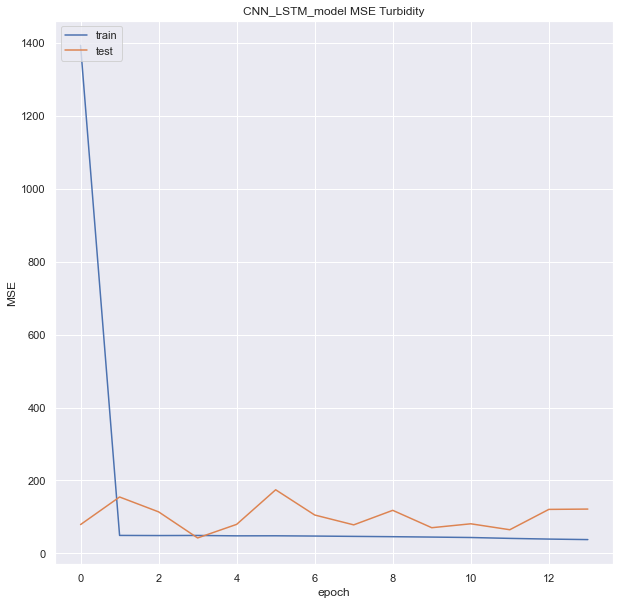

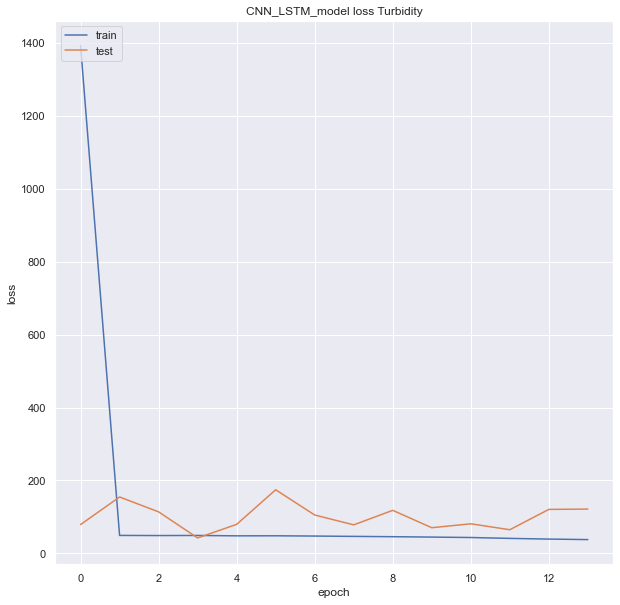

In [39]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('CNN_LSTM_model MSE Turbidity')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_mse_turbidity.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN_LSTM_model loss Turbidity')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_loss_turbidity.png")

483/483 - 2s - loss: 180.2114 - mse: 180.2114 - 2s/epoch - 5ms/step

MSE: 180.21139526367188
483/483 [==============================] - 4s 5ms/step


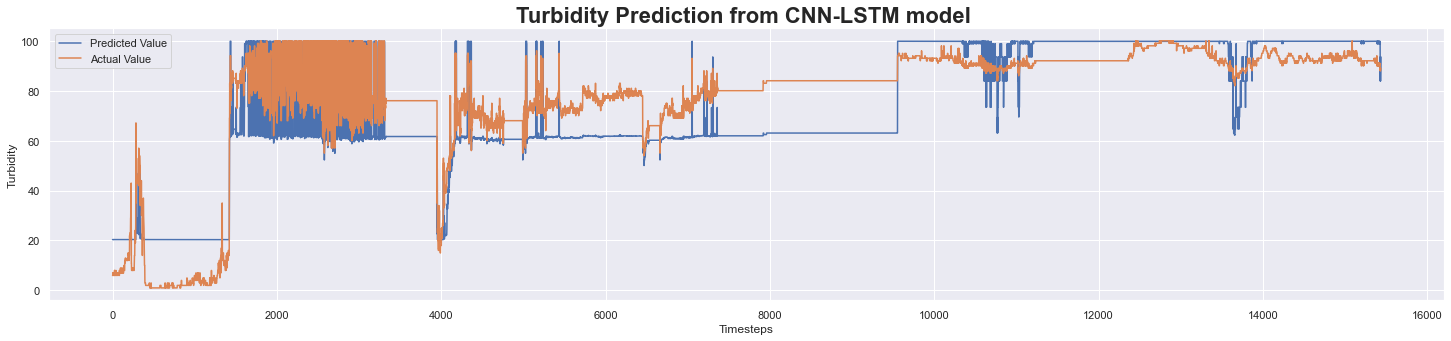

In [40]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('./Predictions/turbidity_predictions.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(25, 5))
# plt.plot(y_pred_test[-100:], label = 'Predicted Value')
# plt.plot(y_true_test[-100:], label = 'Actual Value')
plt.plot(y_pred_test, label = 'Predicted Value')
plt.plot(y_true_test, label = 'Actual Value')
plt.title('Turbidity Prediction from CNN-LSTM model ', fontsize=22, fontweight='bold')
plt.ylabel('Turbidity')
plt.xlabel('Timesteps')
plt.legend()
plt.show()
fig_verify.savefig("./Images/turbidity_predictions.png")

Dissolved Oxygen Predictions


In [41]:
# Turbidity
# X_train = train_df[['Temperature','Dissolved Oxygen']]
X_train = train_df[['Dissolved Oxygen']]
y_train = train_df['Dissolved Oxygen']
# X_test = val_df[['Temperature','Dissolved Oxygen']]
X_test = val_df[['Dissolved Oxygen']]

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

# # Fit the scaler on your training data
# scaler.fit(X_train)

# X_train_norm = scaler.transform(X_train)
# X_test_norm = scaler.transform(X_test)

X_train_norm = X_train
X_test_norm = X_test


In [42]:
# we'll start out with a 2 minute input sequence and a one minute predictive horizon
seq_arrays = []
seq_labs = []
seq_length = 2
ph = 1


num_train_rows=train_df.shape[0]

#create list of sequence length Temperature readings
for start in range(0,num_train_rows-seq_length-ph):
    seq_arrays.append(X_train_norm[start:start+seq_length])
#     seq_arrays.append(train_df[feat_cols].iloc[start:start+seq_length].to_numpy())
    seq_labs.append([train_df['Dissolved Oxygen'].iloc[start:start+seq_length+1].to_numpy()[-1]])

seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [43]:
val_arrays = []
val_labs = []

num_test_rows=val_df.shape[0]

i=1

#create list of Temperature readings starting with a minimum of two readings
for start in range(2,num_test_rows):
    incoming_df=val_df[0:start] 
    
    if len(incoming_df) > seq_length: 
        
        val_arrays.append(X_test_norm[i:i+seq_length])
        val_labs.append([incoming_df['Dissolved Oxygen'].iloc[i:i+seq_length+ph].to_numpy()[-1]])
        i+=1
        
    else:
        
        val_arrays.append(X_test_norm[0:len(incoming_df)])
        val_labs.append([incoming_df['Dissolved Oxygen'].iloc[0:len(incoming_df)+ph].to_numpy()[-1]])
        
# use the pad_sequences function on your input sequences
val_arrays = tf.keras.preprocessing.sequence.pad_sequences(val_arrays, dtype='float32', padding='post',value=val_df["PH"].mean())     

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

In [44]:
print(val_arrays.shape,val_labs.shape,seq_arrays.shape,seq_labs.shape)

(15435, 2, 1) (15435, 1) (61744, 2, 1) (61744, 1)


In [45]:
from keras.layers import Conv1D, BatchNormalization
model_path = './Models/CNN_LSTM_model_dissolvedOx.h5'
# build the network
nb_features = seq_arrays.shape[2]
nb_out = seq_labs.shape[1]
model = Sequential()

model.add(Conv1D(32,input_shape=(seq_length, nb_features),kernel_size=2, padding="causal",activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(48,kernel_size=2,padding="causal",activation="relu",dilation_rate=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(64,kernel_size=2,padding="causal",activation="relu",dilation_rate=4))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(units = nb_out))
model.add(Activation("linear"))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 2, 32)             96        
                                                                 
 batch_normalization_9 (Batc  (None, 2, 32)            128       
 hNormalization)                                                 
                                                                 
 dropout_12 (Dropout)        (None, 2, 32)             0         
                                                                 
 conv1d_10 (Conv1D)          (None, 2, 48)             3120      
                                                                 
 batch_normalization_10 (Bat  (None, 2, 48)            192       
 chNormalization)                                                
                                                                 
 dropout_13 (Dropout)        (None, 2, 48)            

In [46]:
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=50,validation_split=0.05, verbose=2,
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=10, verbose=0, mode='min'),
keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True,mode='min', verbose=0)])
# list all data in history
print(history.history.keys())

Epoch 1/100
1174/1174 - 26s - loss: 37.0287 - mse: 37.0287 - val_loss: 77.8293 - val_mse: 77.8293 - 26s/epoch - 22ms/step
Epoch 2/100
1174/1174 - 10s - loss: 35.3179 - mse: 35.3179 - val_loss: 55.1606 - val_mse: 55.1606 - 10s/epoch - 9ms/step
Epoch 3/100
1174/1174 - 10s - loss: 34.8062 - mse: 34.8062 - val_loss: 78.6448 - val_mse: 78.6448 - 10s/epoch - 9ms/step
Epoch 4/100
1174/1174 - 12s - loss: 34.8548 - mse: 34.8548 - val_loss: 65.4106 - val_mse: 65.4106 - 12s/epoch - 10ms/step
Epoch 5/100
1174/1174 - 11s - loss: 34.5199 - mse: 34.5199 - val_loss: 67.1824 - val_mse: 67.1824 - 11s/epoch - 9ms/step
Epoch 6/100
1174/1174 - 10s - loss: 34.3104 - mse: 34.3104 - val_loss: 51.9853 - val_mse: 51.9853 - 10s/epoch - 8ms/step
Epoch 7/100
1174/1174 - 10s - loss: 34.1284 - mse: 34.1284 - val_loss: 65.0667 - val_mse: 65.0667 - 10s/epoch - 8ms/step
Epoch 8/100
1174/1174 - 10s - loss: 33.9856 - mse: 33.9856 - val_loss: 43.3965 - val_mse: 43.3965 - 10s/epoch - 9ms/step
Epoch 9/100
1174/1174 - 10s - 

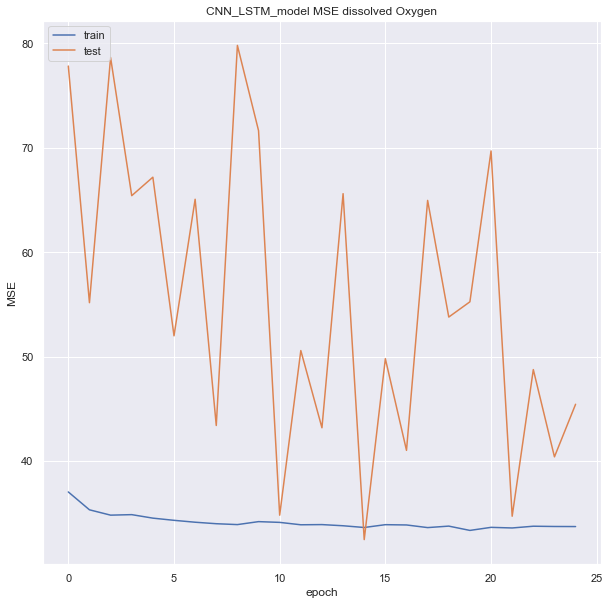

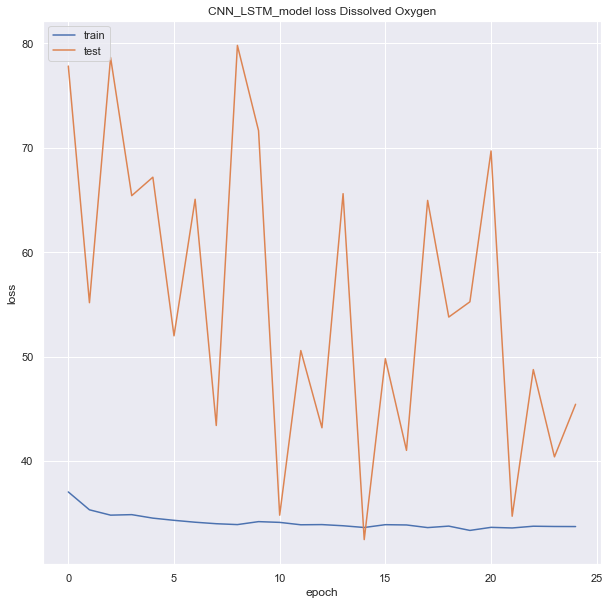

In [47]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('CNN_LSTM_model MSE dissolved Oxygen')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_mse_dissolvedOx.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN_LSTM_model loss Dissolved Oxygen')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_loss_dissolvedOx.png")

483/483 - 2s - loss: 21.7648 - mse: 21.7648 - 2s/epoch - 4ms/step

MSE: 21.76484489440918
483/483 [==============================] - 5s 5ms/step


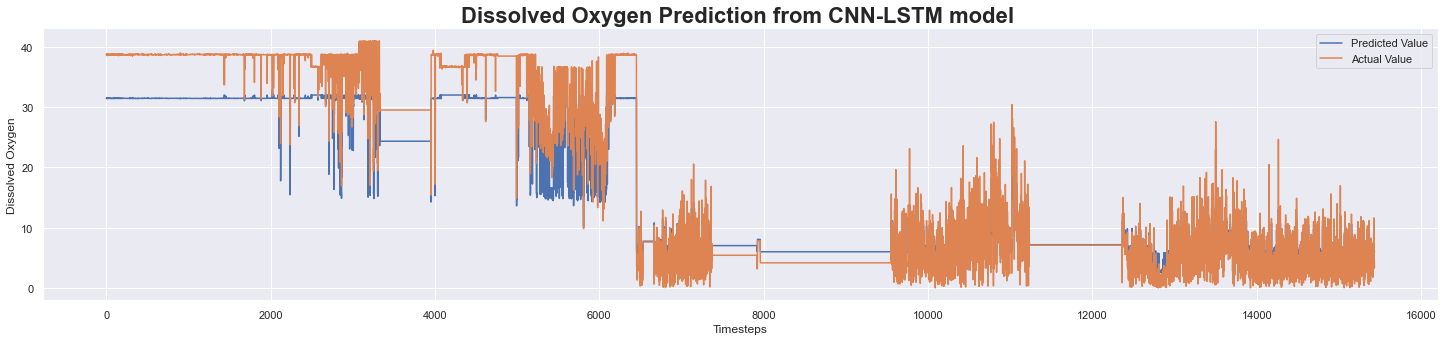

In [48]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('./Predictions/dissolvedOx_predictions.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(25, 5))
# plt.plot(y_pred_test[-100:], label = 'Predicted Value')
# plt.plot(y_true_test[-100:], label = 'Actual Value')
plt.plot(y_pred_test, label = 'Predicted Value')
plt.plot(y_true_test, label = 'Actual Value')
plt.title('Dissolved Oxygen Prediction from CNN-LSTM model ', fontsize=22, fontweight='bold')
plt.ylabel('Dissolved Oxygen')
plt.xlabel('Timesteps')
plt.legend()
plt.show()
fig_verify.savefig("./Images/dissolvedOx_predictions.png")

Ammonia

In [49]:
# X_train = train_df.drop("Temperature",axis=1)
# X_train = train_df[['Turbidity','Ammonia','PH', 'Dissolved Oxygen']]
X_train = train_df[['Ammonia']]
y_train = train_df['Ammonia']
# X_test = val_df.drop("Temperature",axis=1)
X_test = val_df[['Ammonia']]

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

# Fit the scaler on your training data
# scaler.fit(X_train)

# X_train_norm = scaler.transform(X_train)
# X_test_norm = scaler.transform(X_test)

X_train_norm = X_train
X_test_norm = X_test

In [50]:
# we'll start out with a 2 minute input sequence and a one minute predictive horizon
seq_arrays = []
seq_labs = []
seq_length = 2
ph = 1


num_train_rows=train_df.shape[0]

#create list of sequence length Temperature readings
for start in range(0,num_train_rows-seq_length-ph):
    seq_arrays.append(X_train_norm[start:start+seq_length])
#     seq_arrays.append(train_df[feat_cols].iloc[start:start+seq_length].to_numpy())
    seq_labs.append([train_df['Ammonia'].iloc[start:start+seq_length+1].to_numpy()[-1]])

seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [51]:
val_arrays = []
val_labs = []

num_test_rows=val_df.shape[0]

i=1

#create list of Temperature readings starting with a minimum of two readings
for start in range(2,num_test_rows):
    incoming_df=val_df[0:start] 
    
    if len(incoming_df) > seq_length: 
        
        val_arrays.append(X_test_norm[i:i+seq_length])
        val_labs.append([incoming_df['Ammonia'].iloc[i:i+seq_length+ph].to_numpy()[-1]])
        i+=1
        
    else:
        
        val_arrays.append(X_test_norm[0:len(incoming_df)])
        val_labs.append([incoming_df['Ammonia'].iloc[0:len(incoming_df)+ph].to_numpy()[-1]])
        
# use the pad_sequences function on your input sequences
val_arrays = tf.keras.preprocessing.sequence.pad_sequences(val_arrays, dtype='float32', padding='post',value=val_df["PH"].mean())     

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

In [52]:
print(val_arrays.shape,val_labs.shape,seq_arrays.shape,seq_labs.shape)

(15435, 2, 1) (15435, 1) (61744, 2, 1) (61744, 1)


In [53]:
from keras.layers import Conv1D, BatchNormalization
model_path = './Models/CNN_LSTM_model_ammonia.h5'
# build the network
nb_features = seq_arrays.shape[2]
nb_out = seq_labs.shape[1]
model = Sequential()

model.add(Conv1D(32,input_shape=(seq_length, nb_features),kernel_size=2, padding="causal",activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(48,kernel_size=2,padding="causal",activation="relu",dilation_rate=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(64,kernel_size=2,padding="causal",activation="relu",dilation_rate=4))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(units = nb_out))
model.add(Activation("linear"))
optimizer = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 2, 32)             96        
                                                                 
 batch_normalization_12 (Bat  (None, 2, 32)            128       
 chNormalization)                                                
                                                                 
 dropout_16 (Dropout)        (None, 2, 32)             0         
                                                                 
 conv1d_13 (Conv1D)          (None, 2, 48)             3120      
                                                                 
 batch_normalization_13 (Bat  (None, 2, 48)            192       
 chNormalization)                                                
                                                                 
 dropout_17 (Dropout)        (None, 2, 48)            

In [54]:
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=50,validation_split=0.05, verbose=2,
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=10, verbose=0, mode='min'),
keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True,mode='min', verbose=0)])
# list all data in history
print(history.history.keys())

Epoch 1/100
1174/1174 - 26s - loss: 105061740121996394496.0000 - mse: 105061740121996394496.0000 - val_loss: 118.5047 - val_mse: 118.5047 - 26s/epoch - 22ms/step
Epoch 2/100
1174/1174 - 12s - loss: 105061704937624305664.0000 - mse: 105061704937624305664.0000 - val_loss: 351.9515 - val_mse: 351.9516 - 12s/epoch - 10ms/step
Epoch 3/100
1174/1174 - 10s - loss: 105061704937624305664.0000 - mse: 105061704937624305664.0000 - val_loss: 918.6912 - val_mse: 918.6912 - 10s/epoch - 9ms/step
Epoch 4/100
1174/1174 - 10s - loss: 105061678549345239040.0000 - mse: 105061678549345239040.0000 - val_loss: 1827.5382 - val_mse: 1827.5382 - 10s/epoch - 9ms/step
Epoch 5/100
1174/1174 - 10s - loss: 105061748918089416704.0000 - mse: 105061748918089416704.0000 - val_loss: 3060.8083 - val_mse: 3060.8083 - 10s/epoch - 9ms/step
Epoch 6/100
1174/1174 - 10s - loss: 105061740121996394496.0000 - mse: 105061740121996394496.0000 - val_loss: 4558.3413 - val_mse: 4558.3413 - 10s/epoch - 9ms/step
Epoch 7/100
1174/1174 - 10

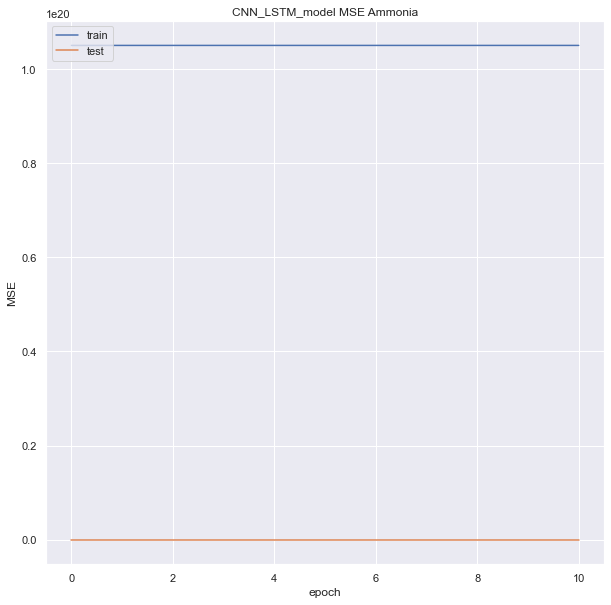

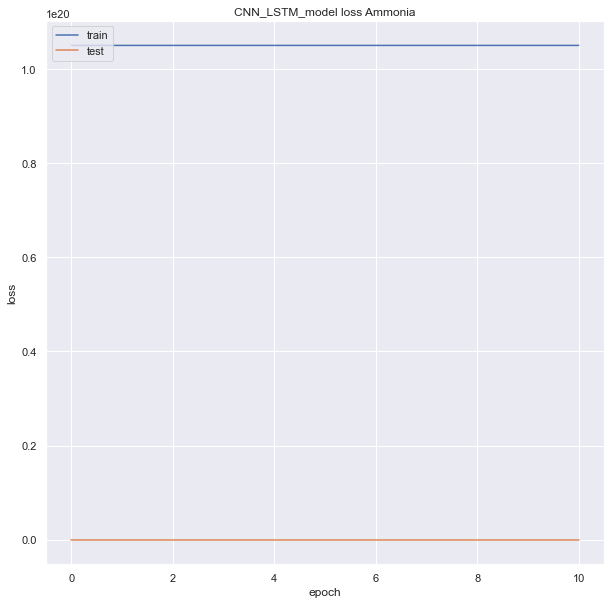

In [55]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('CNN_LSTM_model MSE Ammonia')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_mse_Ammonia.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN_LSTM_model loss Ammonia')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_loss_ammonia.png")


483/483 - 2s - loss: 74172176.0000 - mse: 74172176.0000 - 2s/epoch - 4ms/step

MSE: 74172176.0
483/483 [==============================] - 5s 7ms/step


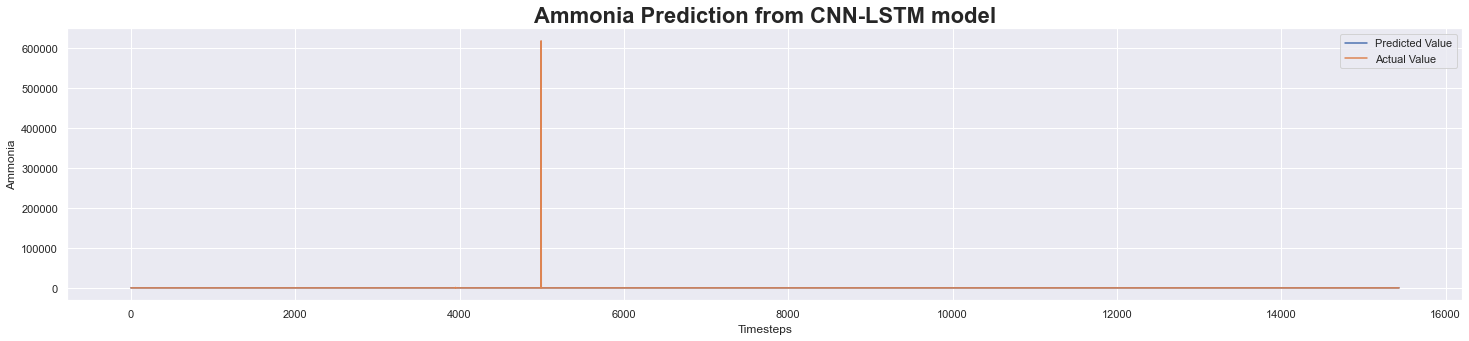

In [56]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('./Predictions/ammonia_predictions.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(25, 5))
# plt.plot(y_pred_test[-100:], label = 'Predicted Value')
# plt.plot(y_true_test[-100:], label = 'Actual Value')
plt.plot(y_pred_test, label = 'Predicted Value')
plt.plot(y_true_test, label = 'Actual Value')
plt.title('Ammonia Prediction from CNN-LSTM model', fontsize=22, fontweight='bold')
plt.ylabel('Ammonia')
plt.xlabel('Timesteps')
plt.legend()
plt.show()
fig_verify.savefig("./Images/Ammonia_Predictions.png")

Nitrate

In [57]:
# X_train = train_df.drop("Temperature",axis=1)
# X_train = train_df[['Turbidity','Ammonia','PH', 'Dissolved Oxygen']]
X_train = train_df[['Nitrate']]
y_train = train_df['Nitrate']
# X_test = val_df.drop("Temperature",axis=1)
X_test = val_df[['Nitrate']]

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

# Fit the scaler on your training data
# scaler.fit(X_train)

# X_train_norm = scaler.transform(X_train)
# X_test_norm = scaler.transform(X_test)

X_train_norm = X_train
X_test_norm = X_test

In [58]:
# we'll start out with a 2 minute input sequence and a one minute predictive horizon
seq_arrays = []
seq_labs = []
seq_length = 2
ph = 1


num_train_rows=train_df.shape[0]

#create list of sequence length Temperature readings
for start in range(0,num_train_rows-seq_length-ph):
    seq_arrays.append(X_train_norm[start:start+seq_length])
#     seq_arrays.append(train_df[feat_cols].iloc[start:start+seq_length].to_numpy())
    seq_labs.append([train_df['Nitrate'].iloc[start:start+seq_length+1].to_numpy()[-1]])

seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [59]:
val_arrays = []
val_labs = []

num_test_rows=val_df.shape[0]

i=1

#create list of Temperature readings starting with a minimum of two readings
for start in range(2,num_test_rows):
    incoming_df=val_df[0:start] 
    
    if len(incoming_df) > seq_length: 
        
        val_arrays.append(X_test_norm[i:i+seq_length])
        val_labs.append([incoming_df['Nitrate'].iloc[i:i+seq_length+ph].to_numpy()[-1]])
        i+=1
        
    else:
        
        val_arrays.append(X_test_norm[0:len(incoming_df)])
        val_labs.append([incoming_df['Nitrate'].iloc[0:len(incoming_df)+ph].to_numpy()[-1]])
        
# use the pad_sequences function on your input sequences
val_arrays = tf.keras.preprocessing.sequence.pad_sequences(val_arrays, dtype='float32', padding='post',value=val_df["PH"].mean())     

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

In [60]:
print(val_arrays.shape,val_labs.shape,seq_arrays.shape,seq_labs.shape)

(15435, 2, 1) (15435, 1) (61744, 2, 1) (61744, 1)


In [61]:
from keras.layers import Conv1D, BatchNormalization
model_path = './Models/CNN_LSTM_model_nitrate.h5'
# build the network
nb_features = seq_arrays.shape[2]
nb_out = seq_labs.shape[1]
model = Sequential()

model.add(Conv1D(32,input_shape=(seq_length, nb_features),kernel_size=2, padding="causal",activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(48,kernel_size=2,padding="causal",activation="relu",dilation_rate=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# model.add(Conv1D(64,kernel_size=2,padding="causal",activation="relu",dilation_rate=4))
# model.add(BatchNormalization())
# model.add(Dropout(0.4))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(units = nb_out))
model.add(Activation("linear"))
optimizer = keras.optimizers.Adam(learning_rate = 1)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 2, 32)             96        
                                                                 
 batch_normalization_15 (Bat  (None, 2, 32)            128       
 chNormalization)                                                
                                                                 
 dropout_20 (Dropout)        (None, 2, 32)             0         
                                                                 
 conv1d_16 (Conv1D)          (None, 2, 48)             3120      
                                                                 
 batch_normalization_16 (Bat  (None, 2, 48)            192       
 chNormalization)                                                
                                                                 
 dropout_21 (Dropout)        (None, 2, 48)            

In [62]:
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500,validation_split=0.05, verbose=2,
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=10, verbose=0, mode='min'),
keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True,mode='min', verbose=0)])
# list all data in history
print(history.history.keys())

Epoch 1/100
118/118 - 14s - loss: 2964.4958 - mse: 2964.4958 - val_loss: 4985.9067 - val_mse: 4985.9067 - 14s/epoch - 115ms/step
Epoch 2/100
118/118 - 3s - loss: 1232.8364 - mse: 1232.8364 - val_loss: 5791.1128 - val_mse: 5791.1128 - 3s/epoch - 21ms/step
Epoch 3/100
118/118 - 2s - loss: 1184.1193 - mse: 1184.1193 - val_loss: 2481.0811 - val_mse: 2481.0811 - 2s/epoch - 21ms/step
Epoch 4/100
118/118 - 2s - loss: 1059.3859 - mse: 1059.3859 - val_loss: 5863.3340 - val_mse: 5863.3350 - 2s/epoch - 19ms/step
Epoch 5/100
118/118 - 2s - loss: 941.4730 - mse: 941.4730 - val_loss: 15320.6787 - val_mse: 15320.6787 - 2s/epoch - 19ms/step
Epoch 6/100
118/118 - 2s - loss: 819.7453 - mse: 819.7453 - val_loss: 7069.8975 - val_mse: 7069.8975 - 2s/epoch - 19ms/step
Epoch 7/100
118/118 - 2s - loss: 789.7332 - mse: 789.7332 - val_loss: 7689.6138 - val_mse: 7689.6138 - 2s/epoch - 20ms/step
Epoch 8/100
118/118 - 2s - loss: 796.8107 - mse: 796.8107 - val_loss: 9095.3760 - val_mse: 9095.3760 - 2s/epoch - 20ms/

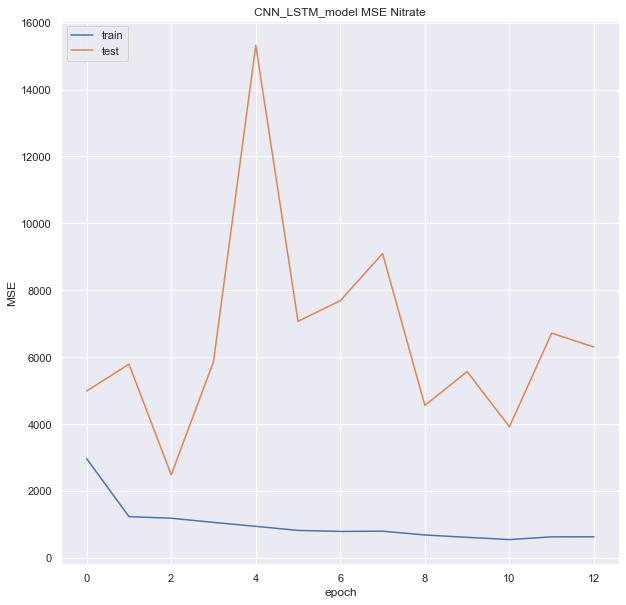

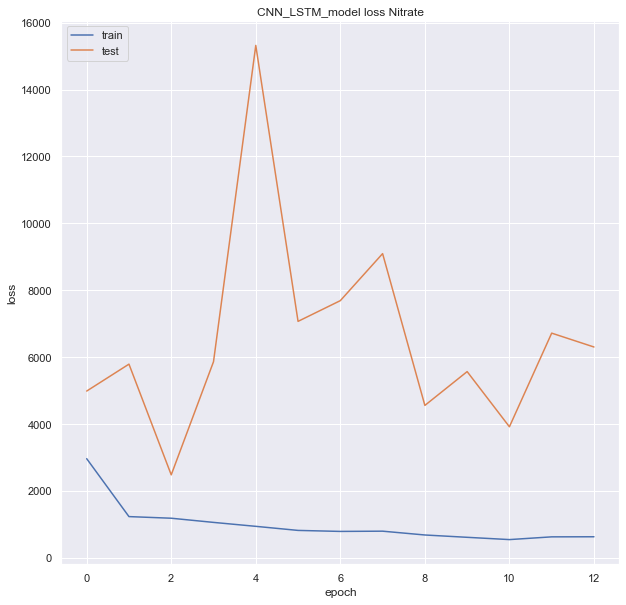

In [63]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('CNN_LSTM_model MSE Nitrate')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_mse_Nitrate.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN_LSTM_model loss Nitrate')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_loss_nitrate.png")


483/483 - 2s - loss: 158265.5469 - mse: 158265.5469 - 2s/epoch - 5ms/step

MSE: 158265.546875
483/483 [==============================] - 4s 4ms/step


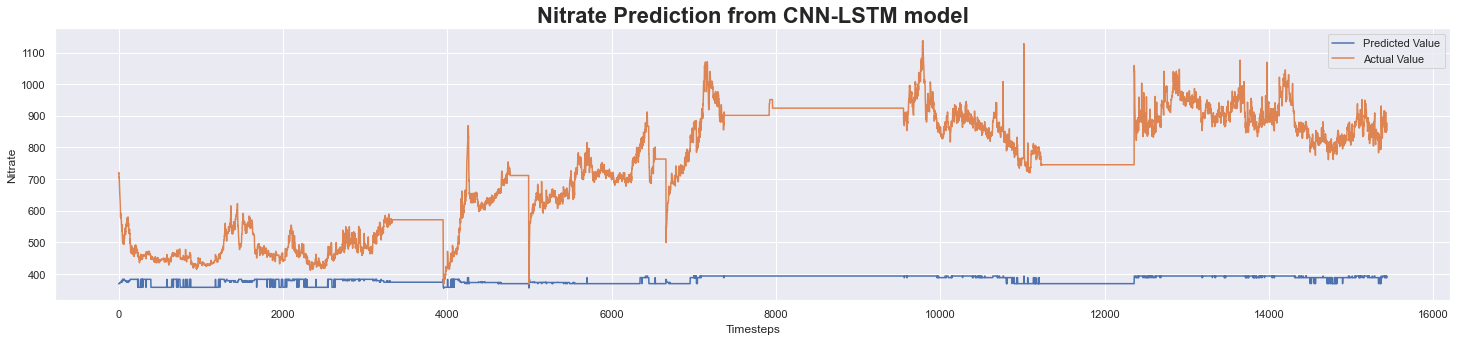

In [64]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('./Predictions/nitrate_predictions.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(25, 5))
# plt.plot(y_pred_test[-100:], label = 'Predicted Value')
# plt.plot(y_true_test[-100:], label = 'Actual Value')
plt.plot(y_pred_test, label = 'Predicted Value')
plt.plot(y_true_test, label = 'Actual Value')
plt.title('Nitrate Prediction from CNN-LSTM model', fontsize=22, fontweight='bold')
plt.ylabel('Nitrate')
plt.xlabel('Timesteps')
plt.legend()
plt.show()
fig_verify.savefig("./Images/Nitrate_Predictions.png")

In [65]:
# Create new DataFrame with "cleaned_pond2" and append the predicted values to it for each timestep for each attribute

combined_df = pd.read_csv('../Data/cleaned_pond2.csv')
combined_df["Temperature_Predict"] = pd.read_csv('./Predictions/temperature_predictions.csv')
combined_df["PH_Predict"] = pd.read_csv('./Predictions/ph_predictions.csv')
combined_df["Turbidity_Predict"] = pd.read_csv('./Predictions/turbidity_predictions.csv')
combined_df["Dissolved Oxygen Predict"] = pd.read_csv('./Predictions/dissolvedOx_predictions.csv')
combined_df["Ammonia_Predict"] = pd.read_csv('./Predictions/ammonia_predictions.csv')
combined_df['Nitrate_Predict'] = pd.read_csv('./Predictions/nitrate_predictions.csv')

# Export the combined DataFrame to a CSV file
combined_df.to_csv('./Predictions/combined_pond.csv', index = None)
combined_df.to_csv('../Data/combined_pond.csv', index = None)
